<a href="https://colab.research.google.com/github/arpeggi-15/TMLC-Fellowship-Task-CV/blob/main/Bark_Texture_Images_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bark Texture Images Classification**

The Dataset used in this notebook can be downlaoded from this page https://www.kaggle.com/datasets/saurabhshahane/barkvn50

From the description of images we can see that there are 5578 images of 50 categories of bark texture. We need to build a model that can classify these images into appropriate category.

Once you download you will find a zip file and upon unzipping you will find a folder named "BarkVN-50". Under this folder, there is a folder named  "BarkVN-50_mendeley" in which there are 50 folders with each having images in it for each category of bark texture. So take the folder "BarkVN-50_mendeley" and move it to your current working directory 

Now let's first import all the required libraries

In [ ]:
##Importing Required Libraries

import os 
import shutil
import numpy as np 
import matplotlib.pyplot as plt 
import random 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator



The "BarkVN-50_mendeley" folder is renamed as "bark_dataset".

Now let's have a look how many images per category we have 

In [ ]:
for dirpath, dirnames, filenames in os.walk("bark_dataset/"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} files in '{dirpath}'.")

The images for each category has been renamed as category1.JPG, category2.JPG. For example images in Acacia folder are named Acacia1.JPG., Acacia2.JPG .....etc.

    Since , the images of different categories can have same name as they are named in the format of IMG_ 3587.JPG. 
    So, it can be a problem while moving the images in different folder.

In [ ]:
all_categories = os.listdir("bark_dataset/")

for category in sorted(all_categories):
    all_images = os.listdir("bark_dataset/" + category + "/" )
    i = 1
    for image in all_images:
        os.rename('bark_dataset/'+ category + "/" + image , 'bark_dataset/' + category + "/" + category + str(i) + ".JPG")
        i += 1

FileNotFoundError: ignored

##Train-Test Splitting

For that I have created a train and est folder in my current working directory. In train folder, 50 folders have been created
for each category of images with the same name as it was in downloaded data 
and have been put all the training data for each category in that same specific category folder. For example
the training data for Acacia category is kept in "train/Acacia/".

Same procedure has been followed for test folder.  For example
the testing data for Acacia category is kept in "test/Acacia/".

In [ ]:
os.makedirs("train")
for category in sorted(all_categories):
    os.makedirs("train/" + category )
    all_images = os.listdir("bark_dataset/" + category + "/")
    for image in random.sample(all_images, int(0.8 * len(all_images))):
        shutil.move("bark_dataset/" + category + "/" + image, "train/" + category + "/")

        
os.makedirs("test")
for category in sorted(all_categories):
    os.makedirs('test/' + category)
    all_images = os.listdir("bark_dataset/" + category + "/")
    for image in all_images:
        shutil.move("bark_dataset/" + category + "/" + image, "test/" + category + "/")

## Creating  a train and test data using ImageDataGenerator 

We needed to modify the file structure as we did above so that we can create batches of training and testing data to be used in Tensorflow model. 
Here, the training and testing data is created using ImageDataGenerator. 


    Note:- normalized pixel values of each image has been used instead of values between 0-255

In [ ]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "train/"
test_dir = "test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", 
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)


Found 4444 images belonging to 50 classes.
Found 1134 images belonging to 50 classes.


## Creating a base model in VGGNet and checking the accuracy metrics of this base model

Since here, the number of images for different categories are not same but the data is not highly 
imbalanced, therefore, accuracy will be used for checking the mterics of the base model.

    Note:- Base model will be trained for only 5 epochs just to check how the model performs

In [ ]:
#defining the model
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, 
                         activation="relu", 
                         input_shape=(224, 224, 3)), 
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, 
                            padding="valid"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(50, activation="softmax") 
])

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Metal device set to: Apple M1


2022-09-27 20:06:12.552802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-27 20:06:12.553565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/5


2022-09-27 20:06:13.219085: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-27 20:06:13.440250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 3.6135 - accuracy: 0.0911

2022-09-27 20:06:33.758824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 23s 143ms/step - loss: 3.6135 - accuracy: 0.0911 - val_loss: 3.1638 - val_accuracy: 0.1887
Epoch 2/5
139/139 [==============================] - 19s 139ms/step - loss: 2.1583 - accuracy: 0.4359 - val_loss: 2.3433 - val_accuracy: 0.4004
Epoch 3/5
139/139 [==============================] - 19s 138ms/step - loss: 0.7006 - accuracy: 0.8245 - val_loss: 2.3528 - val_accuracy: 0.4665
Epoch 4/5
139/139 [==============================] - 19s 138ms/step - loss: 0.1848 - accuracy: 0.9602 - val_loss: 2.4582 - val_accuracy: 0.4621
Epoch 5/5
139/139 [==============================] - 19s 138ms/step - loss: 0.0964 - accuracy: 0.9833 - val_loss: 2.9221 - val_accuracy: 0.4400


## Data Visualization  

History callback returned is used whenever fit function is performed for visualization of the performace.

In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(history.history['loss']))
    
    plt.figure()
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'testing_loss')
    plt.title("loss_curves")
    plt.legend()
    plt.show()
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'validation_accuracy')
    plt.title("accuracy_curves")
    plt.legend()
    plt.show()

### Visualize the performance of the first base model

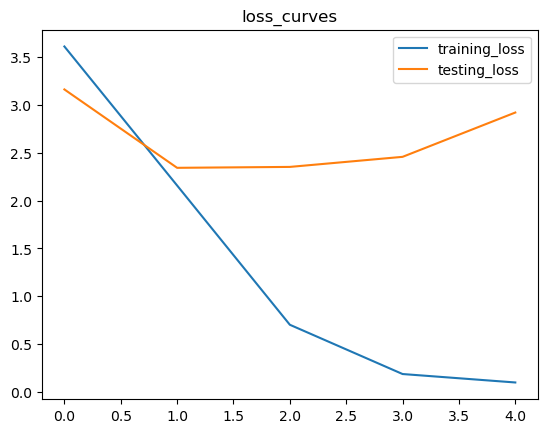

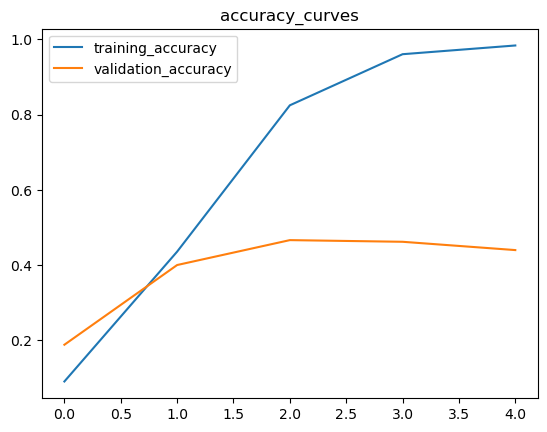

In [ ]:
plot_loss_curves(history_1)

## Overfitting Base Model.

To prevent overfitting, data augmentation and dropout is simultaneously is used in the model.


In [ ]:
train_datagen_aug = ImageDataGenerator(rescale = 1./255, 
                                   horizontal_flip = True, 
                                   vertical_flip = True,
                                   height_shift_range = 0.2, 
                                   width_shift_range = 0.2)


train_data_aug = train_datagen_aug.flow_from_directory(train_dir, 
                                                  batch_size = 32, 
                                                  target_size = (224, 224), 
                                                  class_mode = 'categorical', 
                                                  seed = 42)

Found 4444 images belonging to 50 classes.


## New Model 

This model is same as the base model but has a dropout layer before maxpool layer and is trained on augmented data for more epochs. 

In [ ]:
model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, input_shape = (224, 224, 3), activation = 'relu'), 
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D(2, padding = 'valid'),
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'), 
    tf.keras.layers.Conv2D(filters = 10, kernel_size = 3, activation = 'relu'),
    tf.keras.layers.Dropout(0.4), 
    tf.keras.layers.MaxPool2D(2, padding = 'valid'),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(50, activation = 'softmax')
])


model_2.compile(loss = 'categorical_crossentropy', 
               optimizer = tf.keras.optimizers.Adam(), 
               metrics = ["accuracy"])

history_2 = model_2.fit(train_data_aug, 
                       epochs = 15, 
                       steps_per_epoch = len(train_data_aug),
                       validation_data = test_data, 
                       validation_steps  = len(test_data))

Epoch 1/15


2022-09-27 20:39:24.645796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 3.4492 - accuracy: 0.1229

2022-09-27 20:39:53.514097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 31s 218ms/step - loss: 3.4492 - accuracy: 0.1229 - val_loss: 3.2753 - val_accuracy: 0.1552
Epoch 2/15
139/139 [==============================] - 30s 216ms/step - loss: 2.6332 - accuracy: 0.2797 - val_loss: 2.9067 - val_accuracy: 0.2152
Epoch 3/15
139/139 [==============================] - 30s 218ms/step - loss: 2.3619 - accuracy: 0.3353 - val_loss: 2.4744 - val_accuracy: 0.3395
Epoch 4/15
139/139 [==============================] - 31s 223ms/step - loss: 2.1674 - accuracy: 0.3958 - val_loss: 2.4090 - val_accuracy: 0.3360
Epoch 5/15
139/139 [==============================] - 32s 231ms/step - loss: 2.0188 - accuracy: 0.4354 - val_loss: 2.3754 - val_accuracy: 0.3342
Epoch 6/15
139/139 [==============================] - 33s 235ms/step - loss: 1.9198 - accuracy: 0.4602 - val_loss: 2.0335 - val_accuracy: 0.4674
Epoch 7/15
139/139 [==============================] - 34s 243ms/step - loss: 1.7906 - accuracy: 0.5025 - val_loss: 2.0560 - val_accuracy: 0.3

## Visualise the performance of the new model

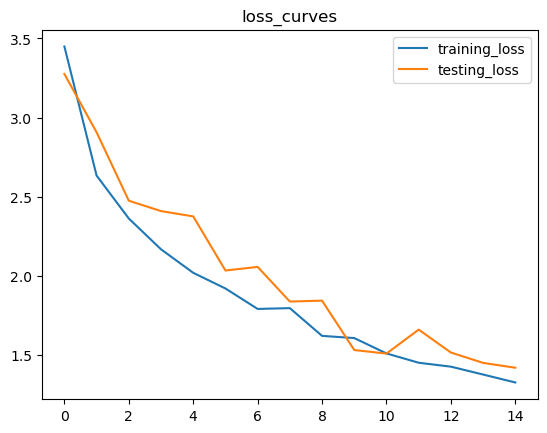

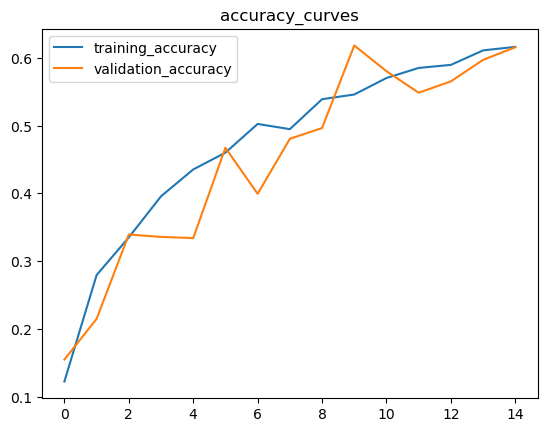

In [ ]:
plot_loss_curves(history_2)

## Using Transfer Learning

Even though the model has low variance, the model is not performing well because it has very high bias now.

    So, Resnet model is used for transfer learning, considering the nature of the problem.




In [ ]:
def create_model(model_url, num_classes = 50):
    #the model url helps to incorporate the architecutre which we want to use in transfer learning. 
    #using this function you can incorporate any architecture by providing the suitable url.
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                            trainable = False, 
                                            input_shape = (224, 224, 3))
    model = tf.keras.Sequential([
        feature_extractor_layer, 
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(num_classes, activation = 'softmax')
    ])
    return model

A dropout of 40 percent before the prediction layer is used and the model is trained for 10 epochs.


In [ ]:
resnet_v2_50_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

resnet_model = create_model(resnet_v2_50_url)

resnet_model.compile(loss = 'categorical_crossentropy', 
                    optimizer = tf.keras.optimizers.Adam(), 
                    metrics = ['accuracy'])

history_resnet_model = resnet_model.fit(train_data, 
                                   epochs = 10, 
                                   steps_per_epoch = len(train_data), 
                                   validation_data = test_data, 
                                   validation_steps = len(test_data))

Epoch 1/10


2022-09-27 21:06:25.522075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - ETA: 0s - loss: 1.9847 - accuracy: 0.5009

2022-09-27 21:07:07.499895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


139/139 [==============================] - 53s 356ms/step - loss: 1.9847 - accuracy: 0.5009 - val_loss: 0.9140 - val_accuracy: 0.7998
Epoch 2/10
139/139 [==============================] - 48s 348ms/step - loss: 0.7585 - accuracy: 0.8096 - val_loss: 0.6345 - val_accuracy: 0.8536
Epoch 3/10
139/139 [==============================] - 49s 349ms/step - loss: 0.5100 - accuracy: 0.8870 - val_loss: 0.5315 - val_accuracy: 0.8810
Epoch 4/10
139/139 [==============================] - 50s 359ms/step - loss: 0.3802 - accuracy: 0.9190 - val_loss: 0.4580 - val_accuracy: 0.8915
Epoch 5/10
139/139 [==============================] - 51s 369ms/step - loss: 0.3014 - accuracy: 0.9390 - val_loss: 0.4192 - val_accuracy: 0.8951
Epoch 6/10
139/139 [==============================] - 52s 374ms/step - loss: 0.2526 - accuracy: 0.9516 - val_loss: 0.3878 - val_accuracy: 0.9048
Epoch 7/10
139/139 [==============================] - 52s 373ms/step - loss: 0.2116 - accuracy: 0.9577 - val_loss: 0.3719 - val_accuracy: 0.9

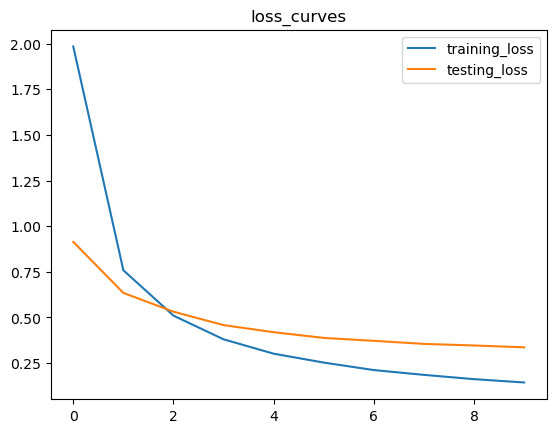

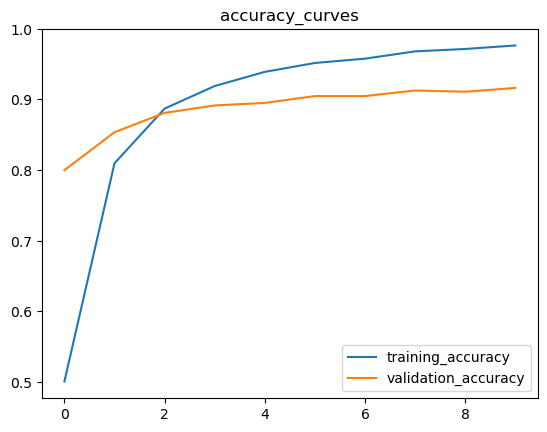

In [ ]:
plot_loss_curves(history_resnet_model)

    The current resnet_model is giving training accuracy of 98% and validation accuracy of 92%.
    So, it is a good model to use and to further predict on unseen data.